# Training Pong Game by Using DQN
We use PyTorch to train a Deep Q Learning (DQN) agent on a Pong Game.

Reference Code: 
 - Pong_in_Pygame (Author: clear-code-projects)
    + Youtube: https://www.youtube.com/playlist?list=PL8ui5HK3oSiEk9HaKoVPxSZA03rmr9Z0k
    + Github: https://github.com/clear-code-projects/Pong_in_Pygame
 - Deep-Q-Learning-Paper-To-Code (Author: philtabor)
    + Youtube: https://www.youtube.com/watch?v=wc-FxNENg9U
    + Github: https://github.com/philtabor/Deep-Q-Learning-Paper-To-Code
 - Reinforcement Learning (DQN) Tutorial(in class colab notebook)
    + https://colab.research.google.com/drive/12M4bu1JUw0zKV2SelwLfxiQ4_aS_WVuH#scrollTo=MA-BKC_ZUMUV 

## **Preparation**
---
Git-clone repository from my [Github](https://github.com/yenzu0329/DQN_for_Pong)

The repo contains
- **result**  (folder that save the training result and demo video)
- dqn.py
- pong.py
- main.py  (code for training DQN model)
- test.py  (code for testing DQN model)

In [2]:
!git clone https://github.com/yenzu0329/DQN_for_Pong.git

Cloning into 'DQN_for_Pong'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 29 (delta 9), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (29/29), done.


### install pygame

In [8]:
!pip install pygame

     |████████████████████████████████| 21.8 MB 1.6 MB/s 


To enable pygame on Colab, we have to fool the system to think it has a video card access.

So we assign a dummy video driver.

And the display is achieved by matplotlib im_show()

In [13]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
%matplotlib inline

## **DQN model**
---


First import necessary libraries

In [25]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

### DeepQNetwork
We define a class for DQN model

The model is an MLP network that takes in the
difference between the current and previous observations. It has **three**
outputs, representing $Q(s, \mathrm{up})$, $Q(s, \mathrm{down})$ and $Q(s, \mathrm{stop})$ (where $s$ is the input to the
network). 

In effect, the network is trying to predict the *expected return* of
taking each action given the current input.

In [26]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        return actions

### Agent
We also define a class for manage and save the model

The class contains 5 methods
- `store_transition` - store (state, action, reward, new_state, terminal) to a cyclic buffer of bounded size that holds the transitions observed recently
- `choose_action` - select an action accordingly to an epsilon greedy policy. Simply put, we'll sometimes use our model for choosing the action, and sometimes we'll just sample one uniformly. The probability of choosing a random action is determined by `epsilon`.
- `learn` - sample a batch of transitions, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. We also use a target network to compute  V(st+1)  for added stability.
- `make_memory` - make a dictionary for saveing memories to a pickle file. The dictionary contains `'state'`, `'action'`, `'reward'`, `'new_state'`, `'terminal'` five keys
- `load_memory` - load memories from a dictionary


In [27]:
class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                max_mem_size = 10000, eps_end = 0.01, eps_dec = 5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0

        self.Q_eval = DeepQNetwork(self.lr, n_actions = n_actions, input_dims=input_dims,
                                    fc1_dims=50, fc2_dims=50)
        self.Q_target = DeepQNetwork(self.lr, n_actions = n_actions, input_dims=input_dims,
                                    fc1_dims=50, fc2_dims=50)
        self.Q_eval.to(self.Q_eval.device)
        self.Q_target.to(self.Q_eval.device)
        self.Q_target.load_state_dict(self.Q_eval.state_dict())
        self.Q_target.eval()

        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, new_state, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = new_state
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.FloatTensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state).to('cpu')
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        batch_idx = np.arange(self.batch_size, dtype = np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        action_batch = self.action_memory[batch]

        q_eval = self.Q_eval.forward(state_batch)[batch_idx, action_batch]
        q_next = self.Q_target.forward(new_state_batch)
        q_next[terminal_batch] = 0.0
        
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        
        self.Q_eval.optimizer.zero_grad()
        loss.backward()
        self.Q_eval.optimizer.step()

        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

    def make_memory(self):
        memory = {}
        memory['state'] = self.state_memory
        memory['new_state'] = self.new_state_memory
        memory['reward'] = self.reward_memory
        memory['action'] = self.action_memory
        memory['terminal'] = self.terminal_memory
        return memory
    
    def load_memory(self, memory):
        self.state_memory = memory['state']
        self.new_state_memory = memory['new_state']
        self.reward_memory = memory['reward']
        self.action_memory = memory['action']
        self.terminal_memory = memory['terminal']

## **Training**
---


First import necessary libraries

In [28]:
import pickle
import torch
from DQN_for_Pong.pong import *
import matplotlib.pyplot as plt
import numpy as np

Below part is the main training loop. At the beginning, we reset the environment and initialize the state Tensor. Then, we sample an action, execute it, get the new observation and reward, and optimize our model once. When the player loses the ball, we restart the loop.

The reward policy show bellow:
- Ball survive: +0.01
- Opponent loss the ball: +3
- Player loss the ball: - (y distance between ball and player)*0.1

If the reward is better than 200, we say that the model is good enough and terminate the training loop. 

After finish training, we save the weights of `agent.Q_eval` and `agent.Q_target` in `policy_net_model.pth` and `target_net_model.pth` files. We also save the transition memory and the chart of training process. Those files can be found in the **result** directory.

Streaming output truncated to the last 5000 lines.
episode5012 -- score -3.93 avg score -6.13 epsilon 0.01
episode5013 -- score -7.49 avg score -6.20 epsilon 0.01
episode5014 -- score -3.21 avg score -6.57 epsilon 0.01
episode5015 -- score -5.99 avg score -6.50 epsilon 0.01
episode5016 -- score -4.29 avg score -6.82 epsilon 0.01
episode5017 -- score -6.93 avg score -6.82 epsilon 0.01
episode5018 -- score -4.93 avg score -6.66 epsilon 0.01
episode5019 -- score -2.43 avg score -6.96 epsilon 0.01
episode5020 -- score -7.93 avg score -7.00 epsilon 0.01
episode5021 -- score -1.93 avg score -7.01 epsilon 0.01
episode5022 -- score -0.43 avg score -6.88 epsilon 0.01
episode5023 -- score -3.77 avg score -6.74 epsilon 0.01
episode5024 -- score -7.49 avg score -6.67 epsilon 0.01
episode5025 -- score -8.43 avg score -6.91 epsilon 0.01
episode5026 -- score -7.49 avg score -7.09 epsilon 0.01
episode5027 -- score  2.93 avg score -7.03 epsilon 0.01
episode5028 -- score -9.49 avg score -7.10 epsilon 0.

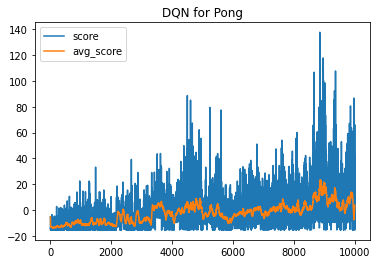

In [31]:
UP = 0
DOWN = 1
STOP = 2

if __name__ == '__main__':
    
    agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=3, input_dims=[4], lr=0.001)
    scores, eps_history = [], []
    avg_scores = []

    player = Player(WIDTH - 10, HEIGHT/2, light_grey)
    opponent = Opponent(5, HEIGHT/2, light_grey)
    paddles = [player, opponent]
    n_games = 10000

    for i in range(n_games):
        # Game objects
        tmp_color = (randint(80,220),randint(80,220),randint(80,220))
        player.color = tmp_color
        opponent.color = tmp_color
        ball = Ball(WIDTH/2, HEIGHT/2, color = tmp_color, paddles = paddles)
        game_manager = GameManager(ball=ball, player=player, opponent=opponent)
        
        done = False
        score = 0.0
        observation = [abs(player.get_x()-ball.get_x()), player.get_y(), ball.get_y(), ball.get_vel_direction()]

        while not done:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    sys.exit()
            action = agent.choose_action(observation=observation)
            if action == UP:            player.move_up()
            elif action == DOWN:        player.move_down()
            else:                       player.stop()
            
            # Background Stuff
            screen.fill(bg_color)
            pygame.draw.rect(screen,light_grey,middle_strip)
            score_label = basic_font.render("Episode: "+str(i), True, light_grey)
            screen.blit(score_label, (10, 10))
            
            # Run the game
            reward = game_manager.run_game()
            if reward == 0:
                score += 0.01
            elif reward == 1:
                score += 3.0
            if reward == -1:
                score -= abs(ball.get_y() - player.get_y()) * 0.1
                done = True
            #done = game_manager.is_done()
            new_observation = [abs(player.get_x()-ball.get_x()), player.get_y(), ball.get_y(), ball.get_vel_direction()]
            agent.store_transition(observation, action, reward, new_observation, done)
            agent.learn()
            observation = new_observation

            # Rendering
            pygame.display.flip()
            clock.tick(500)

        scores.append(score)
        eps_history.append(agent.epsilon)
        if(len(scores) > 50):
            avg_score = 1.0 * np.mean(scores[-50:])
        else:
            avg_score = 1.0 * np.mean(scores)
        avg_scores.append(avg_score)

        if i % 100 == 0:
            agent.Q_target.load_state_dict(agent.Q_eval.state_dict())
        print('episode%4d' % i, '-- score %5.2f' % score, 'avg score %5.2f' % avg_score,
              'epsilon %.2f' % agent.epsilon)
        if score > 200:
            n_games = i + 1
            break

    # print and save model
    print(agent.Q_eval)
    print(agent.Q_target)

    local_dir = os.getcwd()
    result_dir = os.path.join(local_dir, "result")
    if not os.path.isdir(result_dir):
        os.mkdir(result_dir)
    policy_net_path = os.path.join(local_dir, "result/policy_net_model.pth")
    target_net_path = os.path.join(local_dir, "result/target_net_model.pth")
    memory_path = os.path.join(local_dir, "result/memory.pickle")

    torch.save(agent.Q_eval.state_dict(), policy_net_path)        
    torch.save(agent.Q_target.state_dict(), target_net_path)
    with open(memory_path, 'wb') as f:
        pickle.dump(agent.make_memory(), f)

    # draw plot
    x = [i+1 for i in range(n_games)]
    filename = os.path.join(local_dir, 'dqn_for_pong.png')
    fig = plt.figure()
    plt.title("DQN for Pong")
    plt.plot(x, scores, '-', label = 'score')
    plt.plot(x, avg_scores, '-', label = 'avg_score')
    plt.legend()
    fig.savefig(filename)

## **Testing**
---

You can download the **result** directory and the **test.py** file (in DQN_for_Pong directory) to test the training result. Please make sure that the **result** and the **test.py** are in the same directory.

Here is a demo video

In [30]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "/content/DQN_for_Pong/result/demo_video.mp4"

# Compressed video path
compressed_path = "/content/DQN_for_Pong/result/demo_video_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
    <source src="%s" type="video/mp4">
</video>
""" % data_url)